In [77]:
! pip install -U kaleido

In [ ]:
import pandas as pd, re

In [ ]:
gb1900 = pd.read_csv('../data/original/gb1900_gazetteer_complete_july_2018.csv', encoding='utf-16')

In [84]:
# LLM Generated Code #

import pandas as pd, re

# 1. filter out one- or two-letter abbreviations
abbrs = {'F. P.', 'W', 'P', 'F. B.', 'S. P.', 'S. Ps.', 'G. P',
         'B. S.', 'M. S.', 'M. P', 'B. R.', 'B. P.', 'L. B', 'P. O.'}
pat_abbr = re.compile(r'^[A-Z](?:\.\s?)?(?:[A-Z]\.?)?$')

df = (gb1900
      .loc[~(gb1900['final_text'].isin(abbrs) |
             gb1900['final_text'].str.match(pat_abbr))])

# 2. compile your bucket patterns
bucket_patterns = {
    'Hydrology':        r'\b(Spring|Weir|Reservoir|Ford|Waterfall|Dam|Leat|Sluice|Watershed)\b',
    'Extractive':       r'\b(Quarry|Pit|Mine|Shaft|Clay|Chalk|Coal|Lead)\b',
    'Industrial':       r'\b(Mill|Malthouse|Brewery|Works|Factory|Engine House|Smithy|Gasometer|Saw|Brick|Tile|Pottery)\b',
    'Residential':      r'\b(House|Lodge|Farm|Cottage|Barn|Inn)\b',
    'Institutional':    r'\b(Church|Chapel|Vicarage|Rectory|Mission Hall|School|Cemetery|Reading Room)\b',
    'Transport/Infra':  r'\b(Station|Bridge|Ferry|Landing|Road|High Street|Post Office|Quay)\b',
    'Topography':       r'\b(Tumulus|Cairn|Earthwork|Hill|Mount|Arch|Plantation)\b'
}
compiled = {cat: re.compile(pat, re.IGNORECASE) for cat, pat in bucket_patterns.items()}

# 3. helper for bucket assignment
def assign_bucket(txt):
    for cat, rx in compiled.items():
        if rx.search(str(txt)):
            return cat
    return 'Other'

# 4. assign categories without SettingWithCopyWarning
df = df.assign(category=lambda d: d['final_text'].apply(assign_bucket))

In [85]:
# LLM Generated Code #

import plotly.express as px

# 1. compute counts and drop the ‘Other’ slice
counts = (df['category']
          .value_counts()
          .drop('Other')
          .reset_index(name='count'))
counts.columns = ['category', 'count']

# 2. build the pie chart
fig = px.pie(
    counts,
    names='category',
    values='count',
    title='OS Feature Categories (excluding Other)',
    labels={'count':'Number of Features'}
)
fig.update_traces(textinfo='percent+label')  # show both %
fig.show()
fig.write_image("gb-graph1.jpg", width=800, height=600, scale=2)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
df_hydro      = df[df['category'] == 'Hydrology']
df_extractive = df[df['category'] == 'Extractive']
df_industrial = df[df['category'] == 'Industrial']
df_residential= df[df['category'] == 'Residential']
df_institution= df[df['category'] == 'Institutional']
df_transport  = df[df['category'] == 'Transport/Infra']
df_topo       = df[df['category'] == 'Topography']
df_other      = df[df['category'] == 'Other']

In [ ]:
# LLM Generated Code #

import plotly.express as px

# 1. Subset industrial bucket
df_industrial = df[df['category'] == 'Industrial']

# 2. Compute top 15 and reset index so we get two columns
top15 = (
    df_industrial['final_text']
      .value_counts()
      .nlargest(15)
      .reset_index()
)

# 3. Rename for clarity
top15.columns = ['feature', 'count']

# 4. Plot horizontal bar chart
fig = px.bar(
    top15,
    x='count',
    y='feature',
    orientation='h',
    color='count',
    color_continuous_scale='Blues',
    title='Top 15 Industrial/Economic Features',
    labels={'feature':'Feature','count':'Occurrences'},
    text='count'
)

# 5. Tidy up style
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    template='plotly_white',
    margin=dict(l=120, r=40, t=80, b=40)
)
fig.update_traces(textposition='outside', marker_line_width=1, marker_line_color='black')

fig.show()
fig.write_html("industrial.html")


In [ ]:
import re

# 1. Define an expanded list of IR-specific feature keywords
ir_terms = [
    r'\bFactory\b', r'\bFactories\b',
    r'\bWorks\b',
    r'\bEngine House\b',
    r'\bGas Works\b',
    r'\bGasometer\b',
    r'\bFoundry\b',
    r'\bBoiler House\b',
    r'\bOil Refinery\b',
    r'\bPower Station\b',
    r'\bSteam Pump\b',
    r'\bEngine Shed\b',
    # 10 additional IR-era terms:
    r'\bIron Works\b',
    r'\bIronworks\b',
    r'\bRolling Mill\b',
    r'\bBeam Engine\b',
    r'\bSteam Engine\b',
    r'\bChimney\b',
    r'\bChimney Stack\b',
    r'\bGas Holder\b',
    r'\bDockyard\b',
    r'\bCanal Basin\b'
]

# 2. Compile once for efficiency
ir_rx = re.compile('|'.join(ir_terms), flags=re.IGNORECASE)

# 3. Flag your industrial DataFrame
df_ind = df[df['category']=='Industrial'].copy()
df_ind = df_ind.assign(is_ir=lambda d: d['final_text'].str.contains(ir_rx, na=False))

# 4. Split into IR vs. non-IR
df_ir     = df_ind[df_ind['is_ir']].copy()
df_non_ir = df_ind[~df_ind['is_ir']].copy()

# 5. Sanity check
print("IR-era structures:", df_ir.shape[0])
print("Other industrial entries:", df_non_ir.shape[0])


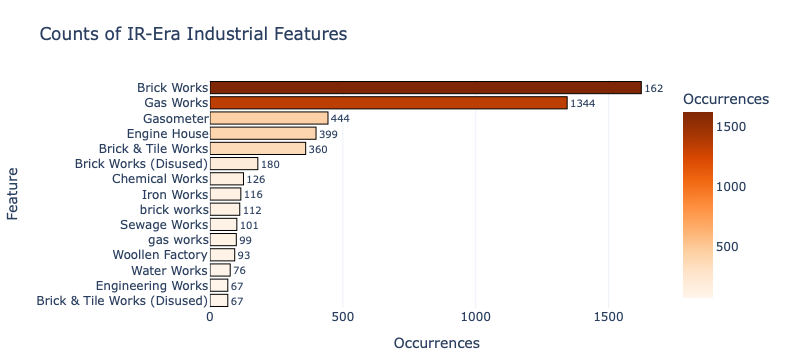

In [90]:
import plotly.express as px

# 1. get counts for each IR-era feature
ir_counts = (
    df_ir['final_text']
      .value_counts()
      .reset_index()
)
ir_counts.columns = ['feature', 'count']

# 2. optional: focus on top 15 (or comment this out to show all)
ir_counts = ir_counts.nlargest(15, 'count')

# 3. create a horizontal bar chart
fig = px.bar(
    ir_counts,
    x='count',
    y='feature',
    orientation='h',
    color='count',
    color_continuous_scale='Oranges',
    title='Counts of IR-Era Industrial Features',
    labels={'feature':'Feature','count':'Occurrences'},
    text='count'
)

# 4. style adjustments
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    template='plotly_white',
    margin=dict(l=140, r=40, t=80, b=40)
)
fig.update_traces(
    textposition='outside',
    marker_line_width=1,
    marker_line_color='black'
)

fig.show()


In [49]:
# LLM Generated Code #

import re

# 1. Start from your Industrial subset (from earlier)
df_ind = df[df['category'] == 'Industrial'].copy()

# 2. Define a granular list of power-generation terms
power_terms = [
    r'\bPower Station\b',
    r'\bOil Refinery\b',
    r'\bGas Works\b',
    r'\bGasometer\b',
    r'\bEngine House\b',
    r'\bBoiler House\b',
    r'\bSteam Pump\b',
    r'\bBeam Engine\b',
    r'\bSteam Engine\b',
    r'\bElectric Works\b',
    r'\bHydraulic Engine\b',
    r'\bCoal Power\b'
]
power_rx = re.compile('|'.join(power_terms), flags=re.IGNORECASE)

# 3. Flag each row if it matches any of the power-generation patterns
df_ind = df_ind.assign(
    is_power=lambda d: d['final_text'].str.contains(power_rx, na=False)
)

# 4. Split into a new DataFrame for power-generation sites only
df_power = df_ind[df_ind['is_power']].copy()

# 5. Sanity check
print("Total industrial entries:", len(df_ind))
print("Power-generation entries:",   len(df_power))
print(df_power['final_text'].value_counts())


Total industrial entries: 48436
Power-generation entries: 2762
final_text
Gas Works                                   1344
Gasometer                                    444
Engine House                                 399
gas works                                     99
engine house                                  46
                                            ... 
Gas Works (Morley Corpn.)                      1
Old Mill Gas Works                             1
Calverley & Horsforth Gas Works                1
clayton gas works (Bradford Corporation)       1
Gas Works (Clitheroe Corpn.)                   1
Name: count, Length: 217, dtype: int64


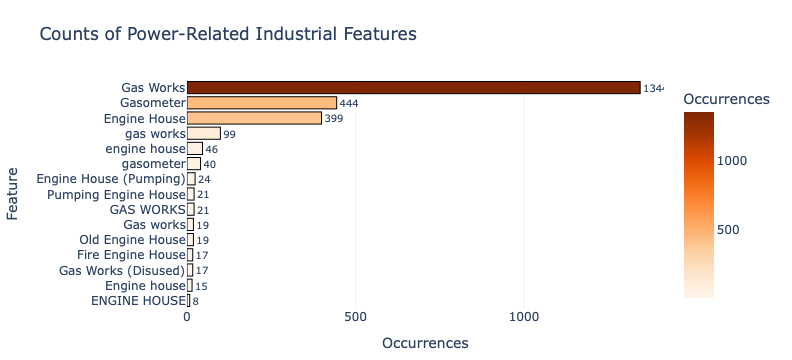

In [66]:
import plotly.express as px

# 1. get counts for each IR-era feature
power_counts = (
    df_power['final_text']
      .value_counts()
      .reset_index()
)
power_counts.columns = ['feature', 'count']


power_counts = power_counts.nlargest(15, 'count')

# 3. create a horizontal bar chart
fig = px.bar(
    power_counts,
    x='count',
    y='feature',
    orientation='h',
    color='count',
    color_continuous_scale='Oranges',
    title='Counts of Power-Related Industrial Features',
    labels={'feature':'Feature','count':'Occurrences'},
    text='count'
)

# 4. style adjustments
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    template='plotly_white',
    margin=dict(l=140, r=40, t=80, b=40)
)
fig.update_traces(
    textposition='outside',
    marker_line_width=1,
    marker_line_color='black'
)

fig.show()
fig.write_html("power.html")
